> # Libraries

In [11]:
# !pip install Augmentor
# import Augmentor

import os
import shutil
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Concatenate, Flatten, Dense
from tensorflow.keras import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt

> # Handle Warnings

> # Define Paths

In [12]:
data_path = '/kaggle/input/studentengagement/Student-engagement-dataset'
target_path = '/kaggle/working/Student-engagement-Dataset'
train_dir = os.path.join(target_path, 'train')
test_dir = os.path.join(target_path, 'test')
valid_dir = os.path.join(target_path, 'validation')

os.makedirs(target_path,exist_ok=True)
os.makedirs(train_dir,exist_ok=True)
os.makedirs(test_dir,exist_ok=True)
os.makedirs(valid_dir,exist_ok=True)

> # Data Preprocessing and Split data into train and test with ratio 20% 

In [13]:
img_size = (256, 256)
for path_ in os.listdir(data_path):
    main_class_dir = os.path.join(data_path, path_)
    for subclass_name in os.listdir(main_class_dir):
        subclass_dir = os.path.join(main_class_dir, subclass_name)

        img_count = len(os.listdir(subclass_dir))                              # Get images coount in each class 
        test_img_count = int(0.2*img_count)                                    # Number of test images
        train_img_count = img_count - test_img_count                           # Number of train images


        target_train_class_dir = os.path.join(train_dir, subclass_name)        
        target_test_class_dir = os.path.join(test_dir, subclass_name)     
        target_valid_class_dir = os.path.join(valid_dir, subclass_name)    

        os.makedirs(target_train_class_dir,exist_ok=True)                      # Create train directory path
        os.makedirs(target_test_class_dir,exist_ok=True)                       # Create test directory path
        os.makedirs(target_valid_class_dir,exist_ok=True)                       # Create validation directory path

        for file_name in os.listdir(subclass_dir):
            img = cv2.imread(os.path.join(subclass_dir, file_name))
            img = cv2.resize(img, img_size)                                    # Resize image to 224 x 224
            img = img / 255.0                                                  # Normalize pixel values to [0, 1]

            if len(os.listdir(target_test_class_dir)) != test_img_count:
                cv2.imwrite(os.path.join(target_test_class_dir, file_name), img)
            else:
                cv2.imwrite(os.path.join(target_train_class_dir, file_name), img)

> # Apply Data Augmentation in Train Data 

In [14]:
# new_train_path = '/kaggle/working/Student-engagement-Dataset/Train'
# os.makedirs(new_train_path,exist_ok=True)

# for class_folder in os.listdir(train_dir):
#     class_dir = os.path.join(train_dir, class_folder)
#     new_class_dir = os.path.join(new_train_path, class_folder)
#     os.makedirs(new_class_dir,exist_ok=True)
#     p = Augmentor.Pipeline(class_dir,new_class_dir)
#     p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
#     p.flip_left_right(probability=0.5)
#     p.zoom_random(probability=0.5, percentage_area=0.8)
#     p.flip_top_bottom(probability=0.5)
#     p.flip_random(probability=0.5)
#     p.sample(500)

# shutil.rmtree(train_dir)
# train_dir = new_train_path

> # Split Train into train and validation

In [15]:
for class_folder in os.listdir(train_dir):
    train_class_dir = os.path.join(train_dir, class_folder)
    valid_class_dir = os.path.join(valid_dir, class_folder)
    
    train_ = os.path.join(target_path,'Train')
    os.makedirs(train_,exist_ok=True)
    new_class_dir = os.path.join(train_,class_folder)
    os.makedirs(new_class_dir,exist_ok=True)
    
    img_count =  len(os.listdir(train_class_dir))                           # Get images coount in each class 
    valid_img_count = int(0.2*img_count)                                    # Number of validation images
    train_img_count = img_count - valid_img_count                           # Number of train images
    
    for file_name in os.listdir(train_class_dir):
        img = cv2.imread(os.path.join(train_class_dir, file_name))
        if len(os.listdir(valid_class_dir)) != valid_img_count:
            cv2.imwrite(os.path.join(valid_class_dir, file_name), img)
        else:
            cv2.imwrite(os.path.join(new_class_dir, file_name), img)
            
shutil.rmtree(train_dir)
train_dir = train_

In [16]:
batch_size = 32
img_size = (256, 256,3)

train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()


train_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size=batch_size,
        class_mode = 'categorical',
        shuffle=True)


val_generator = val_datagen.flow_from_directory(
        valid_dir,
        batch_size=batch_size,
        class_mode = 'categorical',
        shuffle=True)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        batch_size=batch_size,
        class_mode = 'categorical',
        shuffle=True)

print(train_generator.class_indices)

Found 1774 images belonging to 6 classes.
Found 421 images belonging to 6 classes.
Found 421 images belonging to 6 classes.
{'Looking Away': 0, 'bored': 1, 'confused': 2, 'drowsy': 3, 'engaged': 4, 'frustrated': 5}


> # Build Resnet50 Model 

In [17]:
# def inception_module(x, filters):
#     # 1x1 Convolution
#     conv1x1 = Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same', activation='relu')(x)

#     # 1x1 Convolution followed by 3x3 Convolution
#     conv1x1_3x3 = Conv2D(filters=filters[1], kernel_size=(1, 1), padding='same', activation='relu')(x)
#     conv1x1_3x3 = Conv2D(filters=filters[2], kernel_size=(3, 3), padding='same', activation='relu')(conv1x1_3x3)

#     # 1x1 Convolution followed by 5x5 Convolution
#     conv1x1_5x5 = Conv2D(filters=filters[3], kernel_size=(1, 1), padding='same', activation='relu')(x)
#     conv1x1_5x5 = Conv2D(filters=filters[4], kernel_size=(5, 5), padding='same', activation='relu')(conv1x1_5x5)

#     # 3x3 MaxPooling followed by 1x1 Convolution
#     maxpool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
#     conv3x3_1x1 = Conv2D(filters=filters[5], kernel_size=(1, 1), padding='same', activation='relu')(maxpool)

#     # Concatenate the output of all branches
#     inception_output = Concatenate(axis=-1)([conv1x1, conv1x1_3x3, conv1x1_5x5, conv3x3_1x1])
    
#     return inception_output

# # Build the InceptionV2 model
# input_tensor = Input(img_size)
# x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_tensor)
# x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
# x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
# x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
# x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

# # Inception Modules
# x = inception_module(x, filters=[64, 128, 128, 32, 32, 32])
# x = inception_module(x, filters=[128, 192, 96, 96, 64, 64])
# x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

# x = GlobalAveragePooling2D()(x)

# output_tensor = Dense(6, activation='softmax')(x)

# model = Model(inputs=input_tensor, outputs=output_tensor)
# model.summary()



model = keras.models.Sequential([
    keras.layers.Conv2D(32, (1,1), activation='relu', input_shape=img_size),
    keras.layers.MaxPooling2D(3,3),
    keras.layers.Conv2D(64, (1,1), activation='relu'),
    keras.layers.Conv2D(64, (3,3), activation='relu'), 
    keras.layers.MaxPooling2D(3,3),    
    keras.layers.Conv2D(128, (1,1), activation='relu'),
     keras.layers.Conv2D(128, (5,5), activation='relu'),
    keras.layers.MaxPooling2D(3,3),
    keras.layers.Conv2D(256, (1,1), activation='relu'),
     keras.layers.Conv2D(256, (5,5), activation='relu'),
    keras.layers.Flatten(), 
    keras.layers.Dense(512, activation='relu'), 
    keras.layers.Dense(6, activation='softmax')  
])
model.summary()

model.compile(optimizer=Adam() ,loss="categorical_crossentropy", metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 256, 256, 32)      128       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 85, 85, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 85, 85, 64)        2112      
                                                                 
 conv2d_9 (Conv2D)           (None, 83, 83, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 27, 27, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 27, 27, 128)      

In [18]:
checkpoint = ModelCheckpoint("Student Engagement Model.h5", monitor='val_accuracy', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=9, verbose=1, mode='auto')


history = model.fit(train_generator, validation_data= val_generator,
                           epochs=30,callbacks=[checkpoint,early_stopping])

Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 0.5352 - accuracy: 0.7768
Epoch 1: val_accuracy improved from -inf to 0.91924, saving model to Student Engagement Model.h5
56/56 [==============================] - 5s 74ms/step - loss: 0.5352 - accuracy: 0.7768 - val_loss: 0.1537 - val_accuracy: 0.9192
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.9470
Epoch 2: val_accuracy improved from 0.91924 to 0.94062, saving model to Student Engagement Model.h5
56/56 [==============================] - 4s 63ms/step - loss: 0.1195 - accuracy: 0.9470 - val_loss: 0.1263 - val_accuracy: 0.9406
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 0.1069 - accuracy: 0.9532
Epoch 3: val_accuracy did not improve from 0.94062
56/56 [==============================] - 4s 63ms/step - loss: 0.1069 - accuracy: 0.9532 - val_loss: 0.1217 - val_accuracy: 0.9359
Epoch 4/30
55/56 [============================>.] - ETA: 0s - loss: 0.0834 - acc

In [19]:
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

14/14 [==============================] - 1s 48ms/step - loss: 0.0358 - accuracy: 0.9810
Test Loss: 0.0358
Test Accuracy: 0.9810


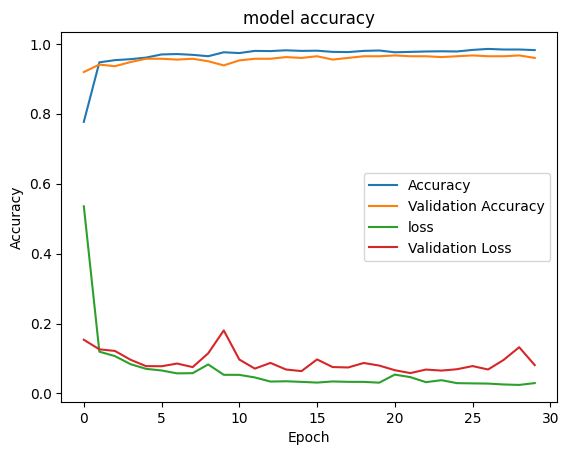

In [20]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()